### TODO


1. I should explore in X space of params that I care about, not flops [eg: token count, param count]
2. I should look into mixture of limited kernels, and explore in that space. ie permutations of kernels, etc.
3. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl

from scaling.constants import *
from scaling.laws import *
from scaling.shared import *

'''load all the data'''

model_dir = "exp_data/models" # has all the loss evaluations
cc_mults = [0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0] # multiply each by 20 to get the token multiplier
datasets = ["c4_original", "rpj", "rw_original"]
downstreams = ["avg", "avg_subset"] # the 46-task and 17-task splits
eval_dir = "exp_data/evals" # has all the downstream evaluations
val_dataset = "c4_val" # dataset for loss computation
df = parse_model_jsons(model_dir, cc_mults=cc_mults, datasets=datasets, eval_dir=eval_dir)
print(f"num models: {len(df.index)}")
print(f"fields: {df.columns.tolist()}")

num models: 104
fields: ['cc_mult', 'dataset_name', 'name', 'model_name', 'N', 'D', 'flops', 'color', 'shape', 'tok_mult', 'loss_openlm', 'loss_upper_openlm', 'loss_lower_openlm', 'loss_c4_val', 'loss_upper_c4_val', 'loss_lower_c4_val', 'loss_paloma_c4_en', 'loss_upper_paloma_c4_en', 'loss_lower_paloma_c4_en', 'loss_paloma_dolma_100_programing_languages', 'loss_upper_paloma_dolma_100_programing_languages', 'loss_lower_paloma_dolma_100_programing_languages', 'loss_paloma_falcon-refinedweb', 'loss_upper_paloma_falcon-refinedweb', 'loss_lower_paloma_falcon-refinedweb', 'loss_paloma_ptb', 'loss_upper_paloma_ptb', 'loss_lower_paloma_ptb', 'loss_paloma_redpajama', 'loss_upper_paloma_redpajama', 'loss_lower_paloma_redpajama', 'loss_val_de-en_100', 'loss_upper_val_de-en_100', 'loss_lower_val_de-en_100', 'err_agi_eval_lsat_ar', 'err_agi_eval_lsat_rc', 'err_agi_eval_lsat_lr', 'err_agi_eval_sat_en', 'err_arc_easy', 'err_arc_challenge', 'err_bbq', 'err_bigbench_conceptual_combinations', 'err_bigbe

In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# df.columns
# len(df.columns)

filter_columns = [col for col in df.columns if not ('upper' in col or 'lower' in col)]
filter_df = df[filter_columns]
filter_df.columns

Index(['cc_mult', 'dataset_name', 'name', 'model_name', 'N', 'D', 'flops',
       'color', 'shape', 'tok_mult', 'loss_openlm', 'loss_c4_val',
       'loss_paloma_c4_en', 'loss_paloma_dolma_100_programing_languages',
       'loss_paloma_falcon-refinedweb', 'loss_paloma_ptb',
       'loss_paloma_redpajama', 'loss_val_de-en_100', 'err_agi_eval_lsat_ar',
       'err_agi_eval_lsat_rc', 'err_agi_eval_lsat_lr', 'err_agi_eval_sat_en',
       'err_arc_easy', 'err_arc_challenge', 'err_bbq',
       'err_bigbench_conceptual_combinations',
       'err_bigbench_conlang_translation', 'err_bigbench_cs_algorithms',
       'err_bigbench_dyck_languages', 'err_bigbench_elementary_math_qa',
       'err_bigbench_misconceptions', 'err_bigbench_language_identification',
       'err_bigbench_logical_deduction', 'err_bigbench_novel_concepts',
       'err_bigbench_operators', 'err_bigbench_repeat_copy_logic',
       'err_bigbench_qa_wikidata', 'err_bigbench_strange_stories',
       'err_bigbench_strategy_qa', 'e

In [3]:

'''fit scaling laws with all the defaults in Table 2 for our paper'''
scaling_law_dict = {}

# NOTE: C4 eval used to as the loss evaluation here
for dataset in datasets:
    for downstream in ["avg", "avg_subset"]:
        # Use 1.4B, M=20 run for fitting the top-1 error scaling laws
        ((a, b, alpha_c, E), (k, gamma, epsilon)), (loss_points, error_points) = fit_ds(
            dataset,
            val_dataset,
            downstream,
            model_dir,
            eval_dir,
            cc_mults,
            True,
            True,
        )
        scaling_law_dict[f"train={dataset}-loss={val_dataset}-downstream={downstream}"] = {
            "loss_scaling": (a, b, alpha_c, E),
            "error_scaling": (k, gamma, epsilon),
            "loss_points": loss_points,
            "error_points": error_points,
        }

relative error predicting (open_lm_1b, M=640.0) C4 eval loss: 0.7103%
relative error predicting (open_lm_7b, M=20.0) C4 eval loss: 0.7320%
relative error predicting (open_lm_1b, M=640.0) 17-task split top-1 error: 3.6365%
relative error predicting (open_lm_7b, M=20.0) 17-task split top-1 error: 0.0464%


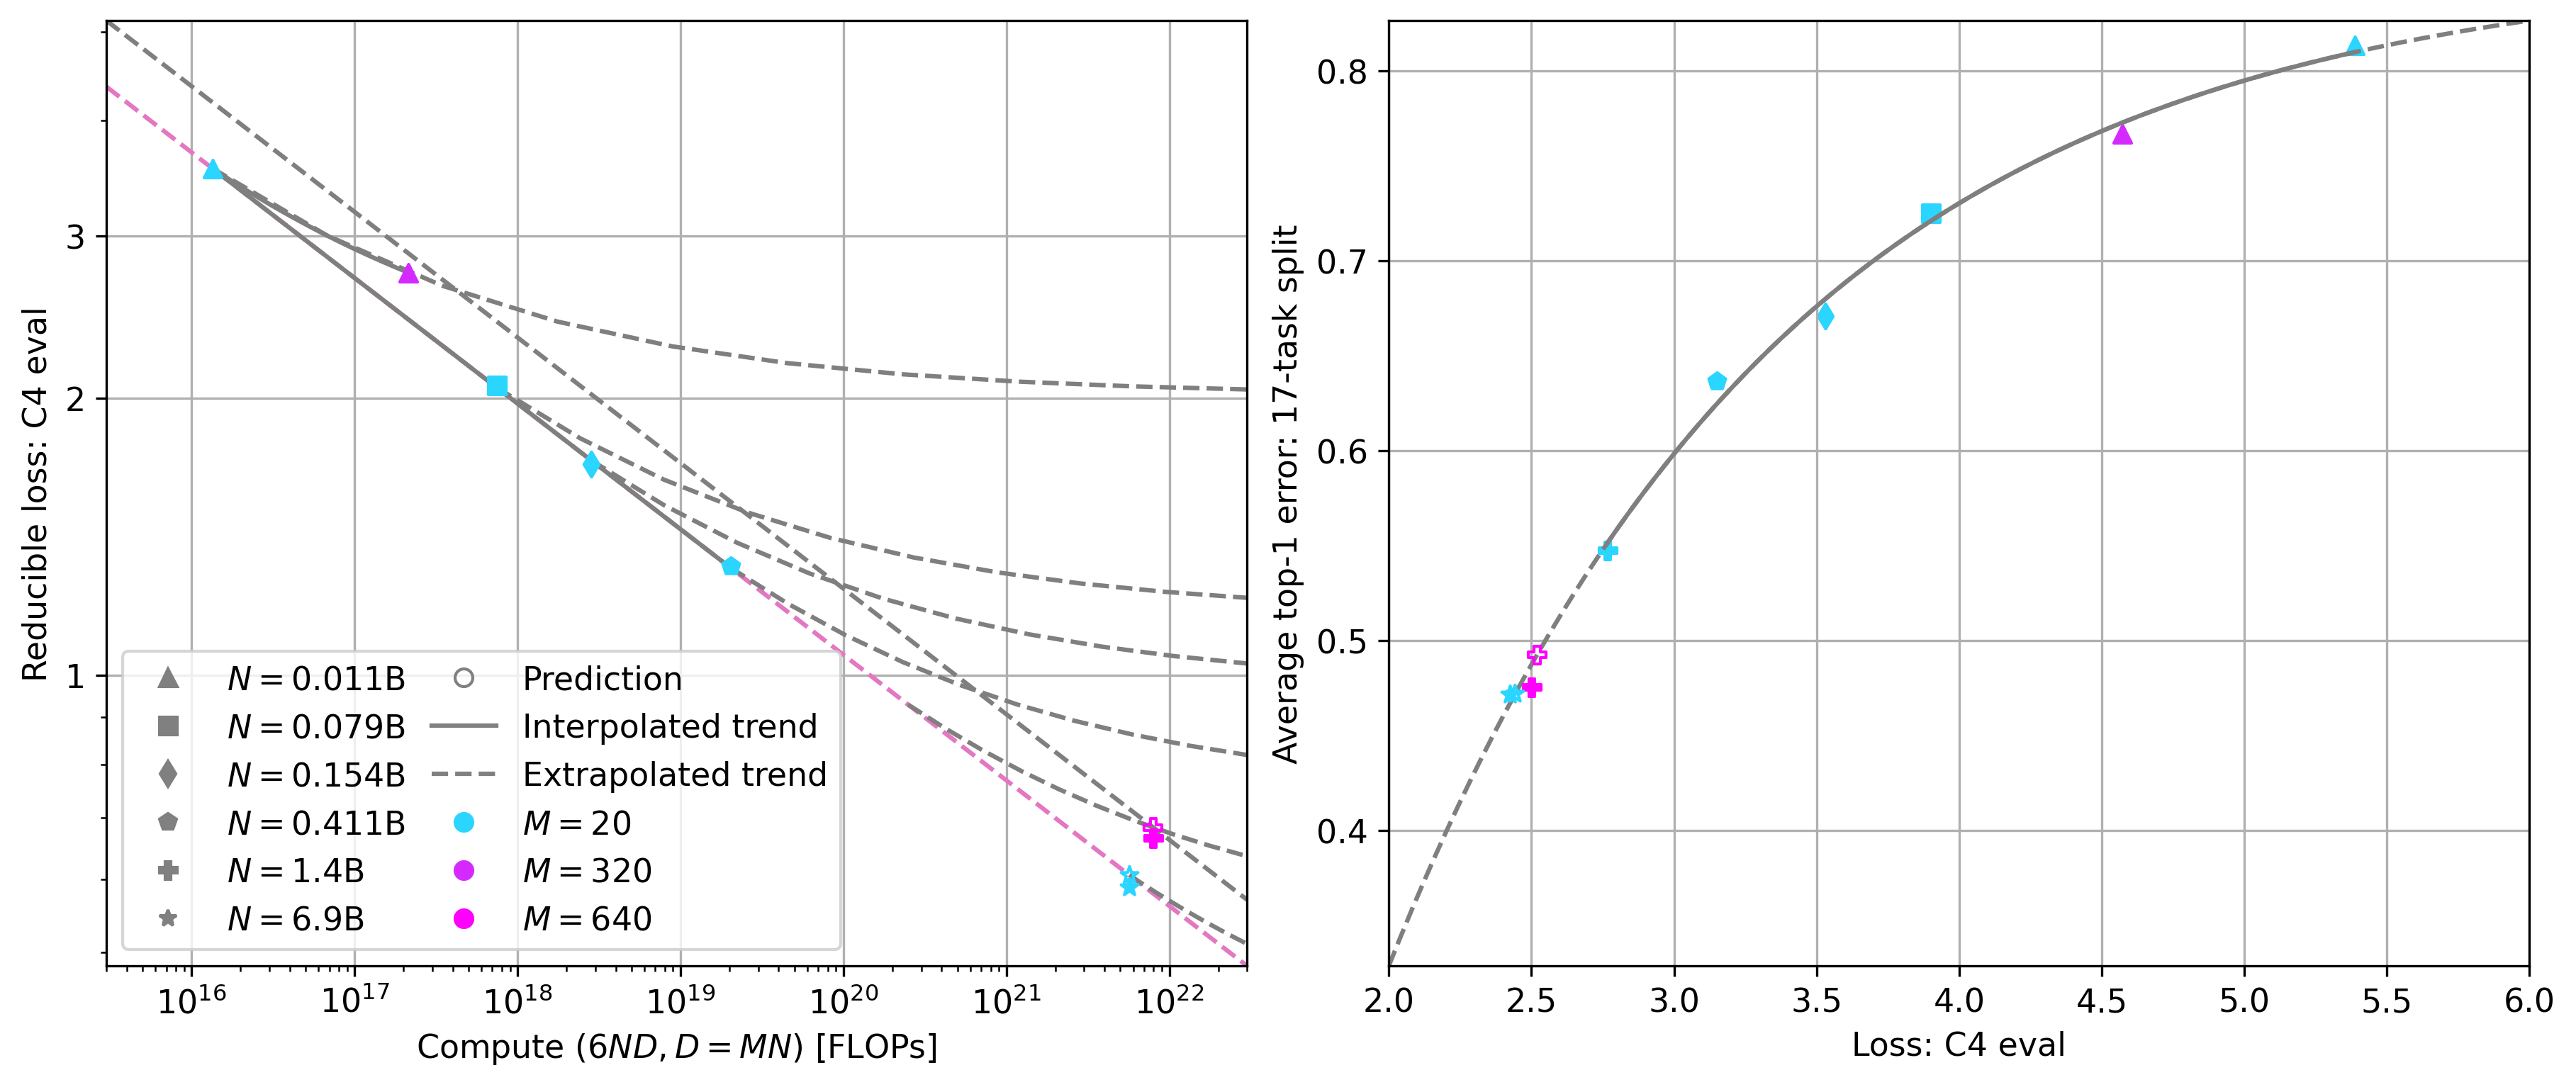

In [4]:
'''reproduce figure 1'''

mpl.rcParams["figure.dpi"] = 300 
font = {
    "size": 11,
}
mpl.rc("font", **font)

# setup axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), constrained_layout=True)

# axis setup
ax = axes[0]
ax_down = axes[1]
ax.set_ylabel(f"Reducible loss: {VAL_FRIENDLIES[val_dataset]}")
ax.set_xlabel("Compute ($6ND, D=MN$) [FLOPs]")
ax.set_yscale("log")
ax.set_yticks([1.0, 2.0, 3.0])
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xscale("log")
ax.grid(which="major", ls="-")
ax.margins(y=0.0, x=0.0)

ax_down.set_ylabel(f"Average top-1 error: {VAL_FRIENDLIES[downstream]}")
ax_down.set_xlabel(f"Loss: {VAL_FRIENDLIES[val_dataset]}")
ax_down.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax_down.grid(which="major", ls="-")
ax_down.margins(y=0.0, x=0.0)



# get the redpajama scaling laws for the 17-task split
(a, b, alpha_c, E) = scaling_law_dict["train=rpj-loss=c4_val-downstream=avg_subset"]["loss_scaling"]
(k, gamma, epsilon) = scaling_law_dict["train=rpj-loss=c4_val-downstream=avg_subset"]["error_scaling"]

cmap = plt.get_cmap("cool")
cNorm = colors.LogNorm(vmin=0.5, vmax=32.0)  # values range from M=10 to M=640 token mults
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

# plot gt points for loss scaling
loss_points = scaling_law_dict["train=rpj-loss=c4_val-downstream=avg_subset"]["loss_points"]
for i in range(len(loss_points["flops"])):
    ax.scatter(
        loss_points["flops"][i],
        loss_points["loss"][i] - E,
        marker=loss_points["shapes"][i],
        color=scalarMap.to_rgba(loss_points["mults"][i]/20.),
        zorder=9,
    )

# plot gt target points
target_df = df[(((df["model_name"] == "open_lm_1b") | (df["model_name"] == "open_lm_7b")) & (df["dataset_name"] == "rpj"))]
target_df = target_df[target_df["flops"] > 248761226153164800000] # dont want the 1.4B, M=20 model
target_flops = target_df["flops"].tolist()
target_loss = target_df[f"loss_{val_dataset}"].tolist()
target_shape = target_df["shape"].tolist()
target_mults = target_df["tok_mult"].tolist()
target_names = target_df["model_name"].tolist()
target_error = target_df[f"err_{downstream}"].tolist()

target_loss_dict = {}

for i in range(len(target_flops)):
    target_loss_dict[(target_names[i], target_mults[i]/20)] = target_loss[i]
    ax.scatter(
        target_flops[i],
        target_loss[i] - E,
        marker=target_shape[i],
        color=scalarMap.to_rgba(target_mults[i]/20.),
        zorder=9,
    )

# plot extrapolation for loss scaling
computes = [3e15, 3e17, 3e18, 3e19, 3e20, 3e22]
n = np.sqrt(np.array(computes).astype(float) / (6 * 32.0 * 20)).tolist()
y = (
    powlaw_ours(
        np.array([n, [640.0] * len(computes)]).astype(float),
        *(a, b, alpha_c, E),
    )
    - E
)
ax.plot(computes, y, linestyle="dashed", color="tab:grey")

n = np.sqrt(np.array(computes).astype(float) / (6 * 1.0 * 20)).tolist()
y = (
    powlaw_ours(
        np.array([n, [20.0] * len(computes)]).astype(float),
        *(a, b, alpha_c, E),
    )
    - E
)
ax.plot(computes, y, linestyle="dashed", color="tab:pink")

for N in sorted(PARAM_SHAPES.keys()):
    start_compute = (N**2) * 20. * 6
    end_compute = 3e22

    ms = []
    for c in np.linspace(np.log10(start_compute), np.log10(end_compute), 10):
        m = np.power(10, c) / ((N**2) * 6)
        ms.append(m)

    xs = ((N**2) * np.array(ms) * 6).tolist()
    ys = (
        powlaw_ours(np.array([[N for _ in range(len(xs))], ms]).astype(float), *(a, b, alpha_c, E))
        - E
    )

    ax.plot(
        xs, ys, color="tab:grey", linestyle="dashed"
    )  
    

# plot interpolation for loss scaling
y = (
    powlaw_ours(
        np.array([[min(loss_points["params"]), max(loss_points["params"])], [20.0, 20.0]]).astype(float),
        *(a, b, alpha_c, E),
    )
    - E
)
ax.plot([min(loss_points["flops"]), max(loss_points["flops"])], y, color="tab:grey")

ms_11m = np.linspace(1.0, 16.0, 100) * 20
ns_11m = [NAME_PARAMS["d=96_l=8_h=4"] for _ in range(len(ms_11m))]
ys_11m = powlaw_ours(np.array([ns_11m, ms_11m.tolist()]), *(a, b, alpha_c, E)).astype(float) - E
xs_11m = [6 * m * 10569312**2 for m in ms_11m]
ax.plot(xs_11m, ys_11m, color="tab:grey")

# plot predictions at 6.9B, 138B tokens and 1.4B, 900B tokens
for name, m in [("open_lm_1b", 32.), ("open_lm_7b", 1.)]:
    N = NAME_PARAMS[name]
    compute = (N**2) * 20 * m * 6
    loss_pred = powlaw_ours(np.array([[N], [20 * m]]), *(a, b, alpha_c, E))
    ax.scatter(
        [compute],
        [loss_pred - E],
        zorder=9,
        marker=PARAM_SHAPES[N],
        facecolors='none',
        edgecolors=scalarMap.to_rgba(m),
    )
    
    gt_loss = target_loss_dict[(name, m)]
    print(f"relative error predicting ({name}, M={m*20}) {VAL_FRIENDLIES[val_dataset]} loss: {abs(loss_pred - gt_loss).item() / gt_loss:.4%}")

# plot gt points for error scaling
error_points = scaling_law_dict["train=rpj-loss=c4_val-downstream=avg_subset"]["error_points"]
for i in range(len(error_points["flops"])):
    ax_down.scatter(
        error_points["loss"][i],
        error_points["error"][i],
        marker=error_points["shapes"][i],
        color=scalarMap.to_rgba(error_points["mults"][i]/20.)
    )



"""
AS: This is where he plots the prediction (transparent) and the error from actual to prediction (% printed)
"""

# target error plotting
target_error_dict = {}

for i in range(len(target_flops)):
    target_error_dict[(target_names[i], target_mults[i]/20)] = target_error[i]
    ax_down.scatter(
        target_loss[i],
        target_error[i],
        marker=target_shape[i],
        color=scalarMap.to_rgba(target_mults[i]/20.),
        zorder=9,
    )

x_range = np.linspace(2.0, 6.0, 100)
ax_down.plot(x_range, decay_ours(x_range, *(k, gamma, epsilon)) , linestyle="dashed", color="tab:grey")

x_range = np.linspace(min(error_points["loss"]), max(error_points["loss"]), 100)
ax_down.plot(x_range, decay_ours(x_range, *(k, gamma, epsilon)), color="tab:grey")

# plot predictions at 6.9B, 138B tokens and 1.4B, 900B tokens
for name, m in [("open_lm_1b", 32.), ("open_lm_7b", 1.)]:
    N = NAME_PARAMS[name]
    compute = (N**2) * 20 * m * 6
    loss_pred = powlaw_ours(np.array([[N], [20 * m]]), *(a, b, alpha_c, E))
    error_pred = decay_ours(loss_pred, *(k, gamma, epsilon))
    
    ax_down.scatter(
        [loss_pred],
        [error_pred],
        zorder=9,
        marker=PARAM_SHAPES[N],
        facecolors='none',
        edgecolors=scalarMap.to_rgba(m),
    )
    
    gt_error = target_error_dict[(name, m)]
    print(f"relative error predicting ({name}, M={m*20}) {VAL_FRIENDLIES[downstream]} top-1 error: {abs(error_pred - gt_error).item() / gt_error:.4%}")

# label=label,
# color=color,
# marker=marker,
# linestyle=linestyle,
labels = []
for name in MODEL_FRINDLIES:
    labels.append(
        ("$N = $" + MODEL_FRINDLIES[name], "grey", MODEL_SHAPES[name], "", "full")
    )

labels.extend(
    [
        ("Prediction", "grey", "o", "", "none"),
        ("Interpolated trend", "grey", "", "-", "full"),
        ("Extrapolated trend", "grey", "", "--", "full"),
        ("$M = 20$", scalarMap.to_rgba(1.0), "o", "", "full"),
        ("$M = 320$", scalarMap.to_rgba(16.0), "o", "", "full"),
        ("$M = 640$", scalarMap.to_rgba(32.0), "o", "", "full"),
    ]
)

legend_helper(ax, labels)

In [5]:
df['flops'].unique()

array([3351310684600320, 6702621369200640, 13405242738401280,
       26810485476802560, 53620970953605120, 107241941907210240,
       186822809152389120, 214483883814420480, 373645618304778240,
       428967767628840960, 708502076827361280, 747291236609556480,
       1417004153654722560, 1494582473219112960, 2834008307309445120,
       2989164946438225920, 5082838266103726080, 5668016614618890240,
       5978329892876451840, 10165676532207452160, 11336033229237780480,
       11956659785752903680, 20331353064414904320, 22672066458475560960,
       23913319571505807360, 40662706128829808640, 45344132916951121920,
       81325412257659617280, 90688265833902243840, 162650824515319234560,
       248761226153164800000, 325301649030638469120,
       650603298061276938240, 995044904612659200000,
       3980179618450636800000, 5695677343708741632000,
       7960359236901273600000], dtype=object)

In [31]:
'''your fun scaling law exploration here!'''
import gpytorch
import torch
from tqdm import trange
from sklearn.model_selection import train_test_split

gpytorch.settings.cholesky_jitter(1e-3) 

class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Prepare training data
X = torch.tensor(df['flops'].values.astype(float), dtype=torch.float)
y = torch.tensor(df['loss_openlm'].values.astype(float), dtype=torch.float)

# Optional filter for data where X is above a certain number
# TODO: GP breaks down when X threshold here is not set, such that the MLE is a degenerate
X_threshold = 1e18  # Example threshold value
mask = X < X_threshold
X = X[mask]
y = y[mask]

X = (X - X.mean()) / X.std()  # Normalize X
y = (y - y.mean()) / y.std()  # Normalize y

# Split data into train and eval sets
train_x, eval_x, train_y, eval_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Training loop
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 200
for i in trange(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    
    # Evaluate on eval set
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        eval_output = model(eval_x)
        eval_loss = -mll(eval_output, eval_y)
    model.train()
    likelihood.train()
    
    print('Iter %d/%d - Train Loss: %.3f   Eval Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(), eval_loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()



 19%|█▉        | 38/200 [00:00<00:00, 186.51it/s]

Iter 1/200 - Train Loss: 1.166   Eval Loss: 1.187   lengthscale: 0.693   noise: 0.693
Iter 2/200 - Train Loss: 1.152   Eval Loss: 1.170   lengthscale: 0.744   noise: 0.644
Iter 3/200 - Train Loss: 1.140   Eval Loss: 1.159   lengthscale: 0.783   noise: 0.598
Iter 4/200 - Train Loss: 1.129   Eval Loss: 1.154   lengthscale: 0.791   noise: 0.555
Iter 5/200 - Train Loss: 1.119   Eval Loss: 1.155   lengthscale: 0.781   noise: 0.514
Iter 6/200 - Train Loss: 1.111   Eval Loss: 1.158   lengthscale: 0.767   noise: 0.477
Iter 7/200 - Train Loss: 1.106   Eval Loss: 1.162   lengthscale: 0.757   noise: 0.442
Iter 8/200 - Train Loss: 1.103   Eval Loss: 1.167   lengthscale: 0.759   noise: 0.411
Iter 9/200 - Train Loss: 1.101   Eval Loss: 1.173   lengthscale: 0.773   noise: 0.384
Iter 10/200 - Train Loss: 1.101   Eval Loss: 1.180   lengthscale: 0.795   noise: 0.361
Iter 11/200 - Train Loss: 1.103   Eval Loss: 1.188   lengthscale: 0.822   noise: 0.342
Iter 12/200 - Train Loss: 1.105   Eval Loss: 1.195  

 28%|██▊       | 57/200 [00:00<00:00, 185.63it/s]

Iter 39/200 - Train Loss: 1.101   Eval Loss: 1.175   lengthscale: 0.804   noise: 0.371
Iter 40/200 - Train Loss: 1.101   Eval Loss: 1.176   lengthscale: 0.807   noise: 0.367
Iter 41/200 - Train Loss: 1.101   Eval Loss: 1.177   lengthscale: 0.813   noise: 0.365
Iter 42/200 - Train Loss: 1.101   Eval Loss: 1.177   lengthscale: 0.822   noise: 0.363
Iter 43/200 - Train Loss: 1.101   Eval Loss: 1.176   lengthscale: 0.834   noise: 0.363
Iter 44/200 - Train Loss: 1.101   Eval Loss: 1.175   lengthscale: 0.846   noise: 0.363
Iter 45/200 - Train Loss: 1.101   Eval Loss: 1.174   lengthscale: 0.858   noise: 0.364
Iter 46/200 - Train Loss: 1.101   Eval Loss: 1.172   lengthscale: 0.868   noise: 0.366
Iter 47/200 - Train Loss: 1.101   Eval Loss: 1.171   lengthscale: 0.875   noise: 0.369
Iter 48/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.879   noise: 0.371
Iter 49/200 - Train Loss: 1.101   Eval Loss: 1.168   lengthscale: 0.880   noise: 0.374
Iter 50/200 - Train Loss: 1.101   Eval Loss

 48%|████▊     | 95/200 [00:00<00:00, 183.39it/s]

Iter 76/200 - Train Loss: 1.101   Eval Loss: 1.167   lengthscale: 0.861   noise: 0.379
Iter 77/200 - Train Loss: 1.101   Eval Loss: 1.167   lengthscale: 0.860   noise: 0.379
Iter 78/200 - Train Loss: 1.101   Eval Loss: 1.168   lengthscale: 0.859   noise: 0.379
Iter 79/200 - Train Loss: 1.101   Eval Loss: 1.168   lengthscale: 0.857   noise: 0.379
Iter 80/200 - Train Loss: 1.101   Eval Loss: 1.168   lengthscale: 0.855   noise: 0.379
Iter 81/200 - Train Loss: 1.101   Eval Loss: 1.168   lengthscale: 0.853   noise: 0.379
Iter 82/200 - Train Loss: 1.101   Eval Loss: 1.168   lengthscale: 0.851   noise: 0.379
Iter 83/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 84/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.847   noise: 0.378
Iter 85/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.844   noise: 0.377
Iter 86/200 - Train Loss: 1.101   Eval Loss: 1.170   lengthscale: 0.842   noise: 0.377
Iter 87/200 - Train Loss: 1.101   Eval Loss

 66%|██████▋   | 133/200 [00:00<00:00, 184.66it/s]

Iter 114/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.847   noise: 0.378
Iter 115/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.848   noise: 0.378
Iter 116/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.848   noise: 0.378
Iter 117/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 118/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 119/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 120/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 121/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.850   noise: 0.378
Iter 122/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.850   noise: 0.378
Iter 123/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 124/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 125/200 - Train Loss: 1.101

 86%|████████▌ | 171/200 [00:00<00:00, 184.76it/s]

Iter 152/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.848   noise: 0.378
Iter 153/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.848   noise: 0.378
Iter 154/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.848   noise: 0.378
Iter 155/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.848   noise: 0.378
Iter 156/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.848   noise: 0.378
Iter 157/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.848   noise: 0.378
Iter 158/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.848   noise: 0.378
Iter 159/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 160/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 161/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 162/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 163/200 - Train Loss: 1.101

100%|██████████| 200/200 [00:01<00:00, 184.09it/s]

Iter 190/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 191/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 192/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 193/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 194/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 195/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 196/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 197/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 198/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 199/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378
Iter 200/200 - Train Loss: 1.101   Eval Loss: 1.169   lengthscale: 0.849   noise: 0.378


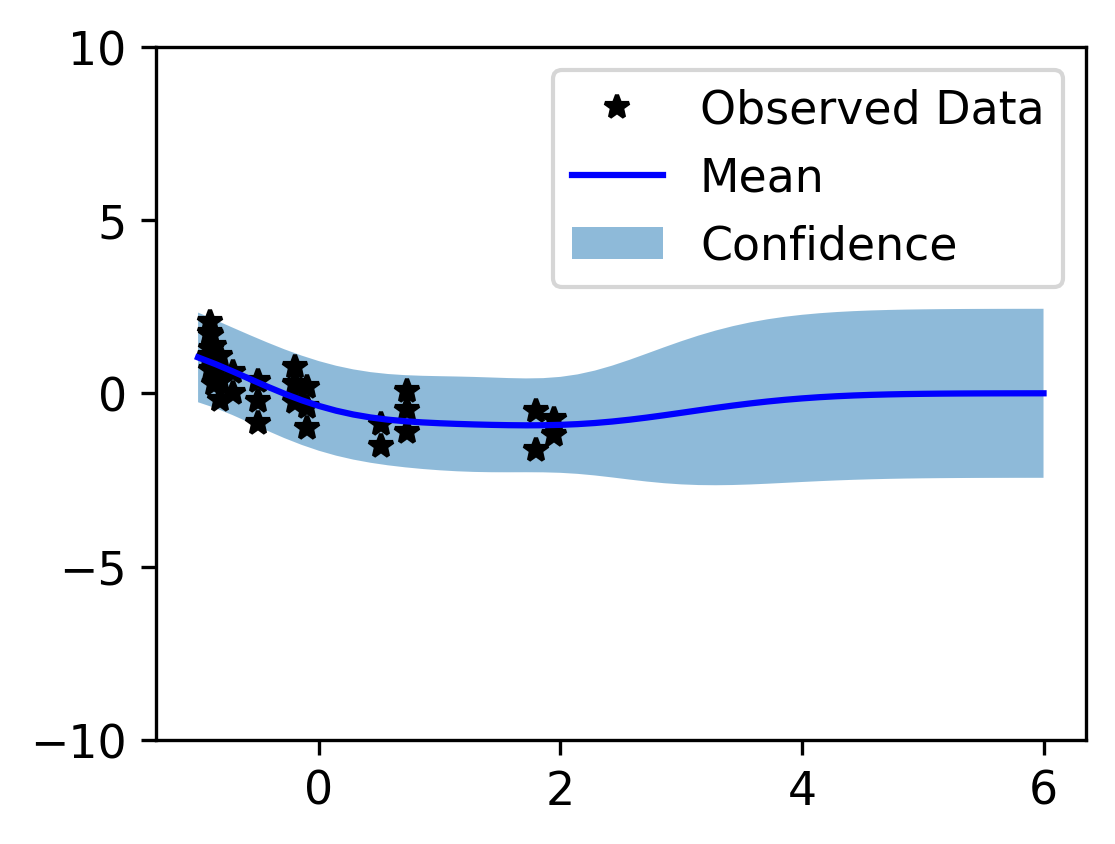

In [29]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are slightly outside the training data range
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-1, 6, 50)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-10, 10])
    # ax.set_xlim([-5, 10])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])